## Data cleaning, processing et modélisation

In [87]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import linear_model, preprocessing, feature_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import mean_squared_error, r2_score, f1_score, median_absolute_error

In [88]:
df = pd.read_csv('Scraping_airbnb2.csv',sep='\t')

In [89]:
df.columns

Index(['Unnamed: 0', 'title', 'price', 'superhost', 'statut', 'grade',
       'nb_comment', 'voyageurs', 'nb_chambres', 'nb_lits', 'nb_sdb', 'city',
       'Cuisine', 'Télévision', 'Sèche-cheveux', 'Chauffage', 'Lave-vaisselle',
       'Eau chaude', 'Draps', 'Wifi', 'Climatisation',
       'Caméras de surveillance extérieure et/ou dans les espaces communs',
       'Entrée privée', 'Jacuzzi', 'Barbecue', 'Équipements de base',
       'Cintres', 'Lave-linge', 'Détecteur de fumée', 'Four à micro-ondes',
       'Réfrigérateur', 'Cuisinière', 'Cafetière', 'Shampooing',
       'Détecteur de monoxyde de carbone', 'Séjours longue durée autorisés',
       'Baignoire', 'Fer à repasser', 'TV avec abonnement standard au câble',
       'Lit pour bébé', 'Lit parapluie', 'Accès plage ou bord de mer',
       'Ascenseur', 'Stationnement payant à l'extérieur de la propriété',
       'Arrivée autonome', 'Logement de plain-pied',
       'Vue panoramique sur la ville', 'Vue sur la piscine', 'Vue sur la bai

<br />
<br />
Dans notre base de données, les valeurs manquantes sont probablement dues à un problème de connexion lors du scraping. <br /> 
La valeur "NC" signifie que l'information recherchée n'apparaissait pas sur la page de l'annonce lors du scraping.
<br />
Par exemple, si le propriétaire n'est pas "Superhôte", le driver inscrit "NC" dans la colonne correspondante. <br />
Pour les équipements, si le bien ne possède pas d'entrée privée, c'est indiqué par un "NC".
<br />

## Exploration des données

<br />
Le dataframe df est composé de 4290 lignes et 73 colonnes. 

In [90]:
df.shape

(4290, 72)

In [91]:
df.columns

Index(['Unnamed: 0', 'title', 'price', 'superhost', 'statut', 'grade',
       'nb_comment', 'voyageurs', 'nb_chambres', 'nb_lits', 'nb_sdb', 'city',
       'Cuisine', 'Télévision', 'Sèche-cheveux', 'Chauffage', 'Lave-vaisselle',
       'Eau chaude', 'Draps', 'Wifi', 'Climatisation',
       'Caméras de surveillance extérieure et/ou dans les espaces communs',
       'Entrée privée', 'Jacuzzi', 'Barbecue', 'Équipements de base',
       'Cintres', 'Lave-linge', 'Détecteur de fumée', 'Four à micro-ondes',
       'Réfrigérateur', 'Cuisinière', 'Cafetière', 'Shampooing',
       'Détecteur de monoxyde de carbone', 'Séjours longue durée autorisés',
       'Baignoire', 'Fer à repasser', 'TV avec abonnement standard au câble',
       'Lit pour bébé', 'Lit parapluie', 'Accès plage ou bord de mer',
       'Ascenseur', 'Stationnement payant à l'extérieur de la propriété',
       'Arrivée autonome', 'Logement de plain-pied',
       'Vue panoramique sur la ville', 'Vue sur la piscine', 'Vue sur la bai


<br />
On supprime la colonne Unnamed: 0 puisqu'elle ne sert à rien. 
<br />

In [92]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

<br />
<br />
On crée une fonction capable de nous donner le nombre de modalités, le taux et le nombre de NC ainsi que le taux et le nombre de valeurs manquantes par colonne. 
<br />

In [93]:
def info(df):
    for col in df.columns :
        rate = (df[col]=='NC').sum()/df.shape[0]
        nc = (df[col]=='NC').sum()
        na = (df[col].isna()).sum()
        rate_na = (df[col].isna()).sum()/df.shape[0]
        if df[col].nunique() <2 :
            print('\033[1;31m' + f"{col} - {df[col].nunique()} modalités - {round(rate,3)} % de NC ({nc}) - {round(rate_na,3)} % de NaN ({na})."+'\033[0m')
        elif rate > 0 :
            print('\033[1;34m' + f"{col} - {df[col].nunique()} modalités - {round(rate,3)} % de NC ({nc}) - {round(rate_na,3)} % de NaN ({na})."+'\033[0m')
        else :
            print(f"{col} - {df[col].nunique()} modalités - {round(rate,3)} % de NC  ({nc}) - {round(rate_na,3)} % de NaN ({na}).")
        

In [94]:
info(df)

title - 3300 modalités - 0.0 % de NC  (0) - 0.0 % de NaN (0).
price - 687 modalités - 0.0 % de NC  (0) - 0.001 % de NaN (5).
superhost - 2 modalités - 0.804 % de NC (3451) - 0.0 % de NaN (0).
statut - 2 modalités - 0.0 % de NC  (0) - 0.079 % de NaN (337).
grade - 102 modalités - 0.0 % de NC  (0) - 0.311 % de NaN (1336).
nb_comment - 205 modalités - 0.0 % de NC  (0) - 0.186 % de NaN (798).
voyageurs - 16 modalités - 0.0 % de NC  (0) - 0.0 % de NaN (0).
nb_chambres - 14 modalités - 0.0 % de NC  (0) - 0.0 % de NaN (0).
nb_lits - 24 modalités - 0.007 % de NC (30) - 0.0 % de NaN (0).
nb_sdb - 14 modalités - 0.0 % de NC  (0) - 0.0 % de NaN (0).
city - 37 modalités - 0.0 % de NC  (0) - 0.0 % de NaN (0).
Cuisine - 2 modalités - 0.021 % de NC (92) - 0.0 % de NaN (0).
Télévision - 2 modalités - 0.406 % de NC (1742) - 0.0 % de NaN (0).
Sèche-cheveux - 2 modalités - 0.162 % de NC (696) - 0.0 % de NaN (0).
Chauffage - 2 modalités - 0.245 % de NC (1049) - 0.0 % de NaN (0).
Lave-vaisselle - 2 modalit

## Nettoyage des données

<br />
On supprime la colonne 'title' puisqu'elle ne nous apporte pas d'informations importantes. 
<br />
On supprime les colonnes 'Parking gratuit' et 'Caméras de surveillance extérieure et/ou dans les espaces communs' parce qu'elles ne contiennent que des NC. Elles seront corrélées en cas de encoding. 

In [96]:
df.drop(['title','Parking gratuit','Caméras de surveillance extérieure et/ou dans les espaces communs'],axis=1,inplace=True)

<br />
<br />
On vérifie l'existence de doublons parfaits. 
<br />

In [97]:
df[df.duplicated(keep=False)]

,price,superhost,statut,grade,nb_comment,voyageurs,nb_chambres,nb_lits,nb_sdb,city,...,Coffre-fort,Ustensiles de barbecue,Patio ou balcon : privé(e),"Jardin privé(e), Clôture intégrale",Piscine,Salle de sport,Animaux acceptés,Dépôt de bagages autorisé,Clés remises par l'hôte,Équipements de cuisine de base
957,800,NC,Professionnel,NaN,NaN,2.0,1,1.0,1,Nice,...,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC
958,800,NC,Professionnel,NaN,NaN,2.0,1,1.0,1,Nice,...,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC


<br /> <br />
On ne garde que la première ligne pour chaque doublons. 
<br />

In [98]:
df.drop_duplicates(keep='first',inplace=True)


### Colonne price

<br />
On s'intéresse maintenant à la colonne qui contient les prix puisque c'est la variable que l'on cherche à estimer. 
<br /> <br />
On trouve 5 lignes pour lesquelles cette variable est manquante. 
<br />

In [99]:
df['price'].isna().sum()

5

<br />
On supprime les lignes concernées et on réinitialise les index. 
<br />

In [100]:
df.dropna(subset=['price'],inplace=True)

In [101]:
df.reset_index(drop=True,inplace=True)

<br />
Grâce aux expressions régulières (regex), on enlève le symbole € dans la colonne des prix. Ensuite, on change le type de la colonne des prix : d'object à int32.
<br />

In [102]:
df['price'] = df['price'].str.replace(r'\D', '').astype(int)

C:\Users\Oussama\AppData\Local\Temp\ipykernel_28816\3721108555.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'\D', '').astype(int)


In [103]:
df['price'] = pd.to_numeric(df['price'])


<br />
On vérifie que tout a bien fonctionné. 
<br />

In [105]:
df['price'].unique()

array([   31,   141,    37,    36,    34,    41,    46,    42,    28,
          32,    47,    40,    29,    35,    26,    39,    33,   126,
          43,    30,    55,    38,    44,    50,   155,   290,   171,
          71,    52,    59,    70,    99,    91,    77,    84,    85,
          90,    94,    76,    80,    87,    79,   104,    83,    81,
          82,    95,   101,    89,    86,   100,    88,    96,   112,
          75,   103,    72,   116,   178,    98,   206,    92,   174,
         153,   180,   128,   150,   186,   161,   147,   152,   151,
         191,   146,   172,   149,   170,   162,   160,   176,   143,
         134,   163,   159,   175,   166,   145,   173,   181,   142,
         177,   190,   169,  1250,   139,   140,   154,   157,   184,
         192,   156,   148,   132,   189,   220,   135,   115,   144,
         179,   129,   200,   199,   209,   188,   212,    61,   185,
          60,   222,   208,   198,   167,   226,   195,   164,   193,
         315,   204,

Nuage de points entre le prix et la variable 0        2.0
1        4.0
2        2.0
3        2.0
4        2.0
        ... 
4279    16.0
4280    16.0
4281    16.0
4282    16.0
4283     6.0
Name: voyageurs, Length: 4284, dtype: float64


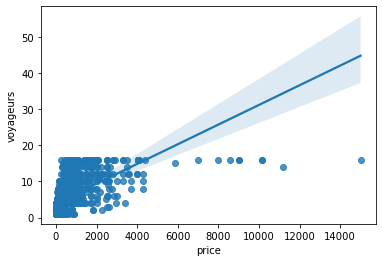

In [106]:
df['voyageurs'].astype(float)
print("Nuage de points entre le prix et la variable", df['voyageurs'])
sns.regplot(x=df["price"], y=df['voyageurs'])
plt.show()

### Colonne superhost

<br />
Pour la colonne 'superhost', on sait qu'il n'y a pas de valeurs manquantes (cf. fonction info) donc on peut directement encoder. <br />

In [107]:
df['superhost'].unique()

array(['NC', 'Superhôte'], dtype=object)

In [108]:
df['superhost'] = np.where(df['superhost']=='Superhôte',1,0)

<br />
On vérifie que le code a bien fonctionné. 
<br />

In [109]:
df['superhost'].unique()

array([0, 1])

### Colonne statut

Pour la colonne "statut", on sait aussi qu'il n'y a pas de valeurs manquantes donc on peut encoder.
<br />
Particulier = 0 <br />
Professionnel = 1 
<br />

In [110]:
df['statut'].unique()

array(['Particulier', 'Professionnel', nan], dtype=object)

In [111]:
df['statut'] = np.where(df['statut']=='Particulier',0,1)

In [112]:
df['statut'].unique()

array([0, 1])

### Colonne des commentaires



Pour la colonne "nb_comment" on remplace les valeurs manquantes par 0 puisque ce sont des cas pour lesquels le driver n'a pas trouvé l'information. On a remarqué que les nouvelles annonces n'avaient aucun commentaire.
<br />

In [113]:
df['nb_comment'] = np.where(df['nb_comment'].isna(),'0 commentaire',df['nb_comment'])

<br />
On enlève le mot "commentaires" et on change le type de la colonne au format int. 

In [114]:
df['nb_comment'] = df['nb_comment'].str.replace(r'\D', '').astype(int)

C:\Users\Oussama\AppData\Local\Temp\ipykernel_28816\888080942.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['nb_comment'] = df['nb_comment'].str.replace(r'\D', '').astype(int)


<br />
On vérifie que le code a bien fonctionné.

In [115]:
df['nb_comment'].unique()

array([ 24,  43,  23,  52,  70,   8,  92,   5,  19,  14,  28,   6,   2,
       241,  39, 121,   4, 153,  37, 157,  99,  59, 268,  35,  17,  90,
        21,  12,   3,  86,  10,  15,  13,  78,  22,   7,  18,  16, 166,
        51,   9,  44, 182,   1,  27,   0,  42,  40, 211, 130,  56, 251,
        32, 101,  20,  47, 222,  65, 206,  87, 172, 164, 103,  55,  75,
        41,  30,  76, 167, 185,  80, 150,  31,  11, 249, 138,  25,  74,
        60, 152,  67,  26,  82, 116, 165, 148,  89,  85,  81, 234,  62,
        96,  93,  29,  38, 134,  48, 104,  33, 137,  34,  53,  58, 216,
        91,  64, 170,  69,  45,  61,  46, 111, 118, 161,  49, 139,  36,
       136, 588,  95,  57,  50, 114,  88, 145,  68, 147, 126, 158,  71,
        54, 232,  66, 252, 174, 256, 180, 160, 156,  63, 100, 123,  79,
       231, 108, 110, 117, 151, 113, 129, 154, 105, 299, 181, 135,  77,
       128, 115,  97, 109, 122, 285,  73, 315, 112, 242, 422, 403, 210,
       120,  72, 106, 119, 132, 246, 282, 215, 173, 159, 176, 19

Nuage de points entre le prix et la variable 0       24
1       43
2       23
3       52
4       70
        ..
4279     0
4280    14
4281     0
4282     1
4283     3
Name: nb_comment, Length: 4284, dtype: int32


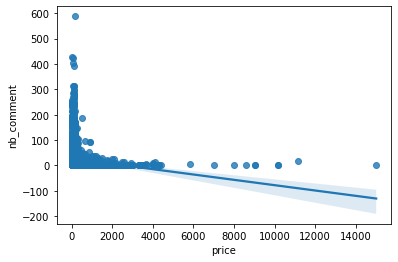

In [116]:
df['nb_comment'].astype(float)
print("Nuage de points entre le prix et la variable", df['nb_comment'])
sns.regplot(x=df["price"], y=df['nb_comment'])
plt.show()

### Colonne des notes

<br />
On commence par transformer les données en float. 
<br />

In [117]:
df['grade'] = df['grade'].str.strip()
df["grade"]=df["grade"].str.replace(',','.')
df['grade'].astype(float)

0       4.92
1       4.95
2       4.52
3       4.58
4       4.45
        ... 
4279     NaN
4280    4.86
4281     NaN
4282     NaN
4283    5.00
Name: grade, Length: 4284, dtype: float64

<br /> On remplace les valeurs manquantes par une valeur aberrante : 9 999.
<br />
On ne peut mettre une note valant 0 à des annonces qui n'en n'ont pas. Par ailleurs, si ces annonces n'ont pas de notes c'est parce qu'elles sont récentes : on crée alors une feature avec 0 pour une annonce récente (sans note) et 1 pour annonce avec note.

In [118]:
df['grade'].unique()

array(['4.92', '4.95', '4.52', '4.58', '4.45', '4.75', '4.65', '3.8',
       '4.74', '4.21', '4.93', '4.6', '4.33', nan, '4.85', '4.49', '4.89',
       '4.62', '4.08', '4.23', '4.79', '4.47', '4.69', '4.8', '4.71',
       '4.88', '4.57', '4.25', '5', '4.73', '4.77', '4.5', '4.29', '4.56',
       '4.72', '4.41', '4.63', '4.17', '4.78', '4.91', '3', '4.94',
       '4.81', '4.43', '4.87', '4.38', '4.9', '4.97', '4.44', '4.66',
       '4.46', '4.86', '4.83', '4.4', '4.96', '4.54', '4.84', '4', '4.51',
       '4.12', '4.68', '4.76', '4.61', '4.67', '4.48', '4.98', '4.82',
       '4.42', '4.7', '3.75', '3.33', '4.3', '4.64', '4.34', '4.16',
       '4.55', '4.24', '4.59', '4.37', '4.32', '3.76', '4.11', '3.5',
       '4.39', '3.25', '4.99', '4.14', '4.53', '4.28', '4.2', '4.13',
       '4.09', '4.19', '3.86', '4.31', '4.36', '4.27', '4.26', '3.67',
       '4.35', '3.69', '3.64', '3.89'], dtype=object)

In [119]:
df['grade'].isna().sum()

1330

In [120]:
df.loc[:,'grade']=df['grade'].fillna(9999.0)

In [121]:
df['grade'].isna().sum()

0

### Colonne du nombre de chambres

In [122]:
df['nb_chambres'].unique()

array(['1', 'S', '2', '3', '4', '6', '8', '7', '5', '9', '10', '11', '12',
       '15'], dtype=object)

Le 'S' signifie Studio est pose problème : on le remplace par 0 étant donné qu'il n'y a pas de chambre dans un studio. 

In [123]:
df['nb_chambres'] = np.where(df['nb_chambres']=='S',1,df['nb_chambres'])

### Colonne du nombre de salles de bain

Il n'y a aucune valeur manquante dans cette colonne (cf. fonction info) donc on n'a aucun traitement à appliquer. 
<br />

### Colonne du nombre de lits

<br />
    On doit supprimer les lignes contenant des NC puisqu'on ne sait vraiment pas combien de chambres il y a pour ces annonces. 

In [124]:
df.drop(df[df['nb_lits']=='NC'].index,inplace=True)

### Colonnes des équipements

<br />
Grâce à la fonction info, on sait que les colonnes des équipements possèdent 2 modalités, à savoir : "NC" ou le nom de l'équipement. 
<br />
On encode 0 pour "NC" et 1 quand il y a l'équipement.

In [125]:
def NC(x):
    if x == 'NC':
        return 0
    elif x==x :
        return 1
    else : pass

In [126]:
df.shape

(4254, 68)

<br />
On fait attention à la dernière colonne : elle est déjà encodée.

In [127]:
df.columns[67]

'Équipements de cuisine de base'

In [128]:
for col in df.columns[10:68] :
        df[col] = df[col].apply(NC)

<br />
On vérifie que le code a bien fonctionné.
<br />

In [129]:
df

,price,superhost,statut,grade,nb_comment,voyageurs,nb_chambres,nb_lits,nb_sdb,city,...,Coffre-fort,Ustensiles de barbecue,Patio ou balcon : privé(e),"Jardin privé(e), Clôture intégrale",Piscine,Salle de sport,Animaux acceptés,Dépôt de bagages autorisé,Clés remises par l'hôte,Équipements de cuisine de base
1,141,0,1,4.95,43,4.0,1,2.0,0,Nice,...,0,0,0,0,0,0,0,1,0,1
2,37,1,0,4.52,23,2.0,1,1.0,1,Nice,...,0,0,0,0,0,0,1,0,0,0
3,37,0,0,4.58,52,2.0,1,1.0,1,Nice,...,0,0,1,0,0,0,0,0,0,1
4,36,0,0,4.45,70,2.0,1,1.0,1,Nice,...,0,0,0,0,0,0,0,0,0,1
5,34,0,0,4.75,8,2.0,1,1.0,1,Nice,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,10170,0,1,9999.0,0,16.0,10,10.0,11,Sainte-Maxime,...,0,0,0,0,1,0,0,0,0,0
4279,2786,0,1,9999.0,0,16.0,12,12.0,12,Sainte-Maxime,...,0,0,0,0,0,0,0,0,0,0
4280,4094,0,0,4.86,14,16.0,11,26,12,Cannes,...,0,0,0,0,1,1,0,1,0,1
4281,4048,0,1,9999.0,0,16.0,11,26,12,Cannes,...,0,0,0,0,1,1,0,1,0,1


<br />
Reset des index

In [130]:
df.reset_index(drop=True,inplace=True)

<br />
On n'utilise pas la colonne 'city' : en faisant du one-hot-encoding et en intégrant ces valeurs, nos modèles faisaient trop d'underfitting. 

In [131]:
df.drop(['city'],axis=1,inplace=True)

## Séléction des features pour une régression

<br />
On stocke le prix dans y. 
<br />

In [132]:
y = df.pop('price')

In [133]:
X = df

<br />
On effectue une sélection de variables en se basant sur un test statistique, le test du Chi-deux qui nous donne la significativité des variables et on ne garde que les 50 variables les plus importantes.
On fait le choix de 50 variables, car nous avons remarqué que pour notre régression, nous avions besoin de plusieurs variables.
<br />

In [134]:
chi2(X,y)

(array([6.66177942e+02, 5.22973426e+02, 9.69767305e+06, 6.73569046e+04,
        6.29517836e+03, 3.73029913e+03, 5.55747676e+03, 3.42558405e+03,
        1.93041435e+01, 3.54679282e+02, 1.71545049e+02, 2.20864780e+02,
        6.12785478e+02, 2.81046727e+02, 3.32512214e+02, 7.51427037e+01,
        4.62187776e+02, 6.65032781e+02, 1.59114423e+03, 1.48381208e+03,
        1.32459479e+02, 1.91963933e+02, 2.79652229e+02, 1.64639567e+02,
        2.97593385e+02, 2.53596397e+02, 5.18801623e+02, 4.55629539e+02,
        4.37900928e+02, 6.93444072e+02, 8.36739982e+01, 7.76785186e+02,
        1.68063589e+02, 6.94396284e+02, 9.83812969e+02, 7.52207426e+02,
        5.78376573e+02, 6.28001233e+02, 5.58131063e+02, 6.98981538e+02,
        5.84881320e+02, 7.22359613e+02, 1.36044292e+03, 9.09241673e+02,
        8.84651539e+02, 9.02739651e+02, 8.82920741e+02, 9.99155694e+02,
        9.74988480e+02, 1.03245119e+03, 6.51044590e+02, 5.69901004e+02,
        7.02923561e+02, 1.02075967e+03, 5.77020991e+02, 2.400108

<br />
On lui demande un maximum de features pour minimiser l'underfitting. 
<br />

In [189]:
selector = SelectKBest(chi2,k='all')
selector.fit_transform(X,y)

array([['4.95', 43, 4.0, '1', '2.0', 0],
       ['4.52', 23, 2.0, 1, '1.0', 1],
       ['4.58', 52, 2.0, 1, '1.0', 1],
       ...,
       ['4.86', 14, 16.0, '11', '26', 12],
       [9999.0, 0, 16.0, '11', '26', 12],
       [9999.0, 1, 16.0, '15', '17.0', 14]], dtype=object)

<br />
On visualise les features qui ont été sélectionnées. 
<br />

In [190]:
np.array(X.columns)[selector.get_support()]

array(['grade', 'nb_comment', 'voyageurs', 'nb_chambres', 'nb_lits',
       'nb_sdb'], dtype=object)

<br />
On crée un nouveau dataframe en gardant les variables sélectionnées. 

In [191]:
dfkeep = df[list(np.array(X.columns)[selector.get_support()])]

In [192]:
X = dfkeep

<br />
On divise le dataframe : 70 % train et 30 % test.

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

## Regression RandomForest

<br />
On fait une regression RandomForest en cherchant les meilleures paramètres à l'aide de la mean squared error. On fait aussi une cross-validation=7. 

Résultats à obtenir : max_depth : 50 ; n_estimators : 150

In [57]:
# Random Forests
parameters = [{'max_depth': [5,10, 15, 20, 50, 70], 'n_estimators': [10, 25, 50, 100,150, 200, 250]}]
MSERF = ['mean_squared_error(y_test, y_pred)']
for value in MSERF:
    reg_rf = RandomizedSearchCV(RandomForestRegressor(), parameters, cv=7)
    reg_rf.fit(X_train, y_train)
    y_true, y_pred = y_test, reg_rf.predict(X_test)
    
print('Meilleurs hyper-paramètres : ',reg_rf.best_params_)      

The best hyper-parameters for Random Forests are:  {'n_estimators': 150, 'max_depth': 50}


In [140]:
reg_rf1 = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=150)

In [141]:
forest = reg_rf1.fit(X_train, y_train)

In [142]:
forest.score(X_train,y_train)

0.8566635688139834

In [145]:
forest.score(X_test,y_test) 

0.8317187500686898

## Classification RandomForest

<br />
La séléction des variables par le Chi-deux donne de très bon résultats avec le Classifier. <br />
Résultats à obtenir : max_depth : 15 ; n_estimators : 250

In [66]:
# Random Forests
parameters = [{'max_depth': [5,10, 15, 20, 50, 70], 'n_estimators': [10, 25, 50, 100,150, 200, 250]}]
MSERF = ['mean_squared_error(y_test, y_pred)']
for value in MSERF:
    classification_rf = GridSearchCV(RandomForestClassifier(), parameters, cv=4)
    classification_rf.fit(X_train, y_train)
    y_true, y_pred = y_test, classification_rf.predict(X_test)
    
print('Meilleurs hyper-paramètres :', classification_rf.best_params_) 

C:\Users\sonia\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


The best hyper-parameters for Random Forests are: {'max_depth': 15, 'n_estimators': 250}


In [175]:
classification_rf = RandomForestClassifier(max_depth=15, random_state=0, n_estimators=250)

In [176]:
forest2 = classification_rf.fit(X_train, y_train)

In [200]:
forest2.score(X_train,y_train)

In [179]:
forest2.score(X_test,y_test) 

0.8183241973375098

In [201]:
y_pred2 = classification_rf.predict(X_test)

<br />
Le f1-score est une métrique qui permet d'évaluer la performance des modèles de classification à deux classes ou plus. 
Le f1-score permet de résumer les valeurs de la précision et du recall en une seule métrique. <br />
Mathématiquement, ce score est défini comme étant la moyenne harmonique de la précision et du recall.

In [204]:
f1 = f1_score(y_test,y_pred2,average='weighted',labels=np.unique(y_pred2))

In [205]:
f1

0.845937639731682